In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = p.cummax()
    dd = p / hmax - 1

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])

        return res

    ret = adjnav.pct_change()
    # annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / 1) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr, format='%Y-%m-%d'):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, format).date()

def date_count_in_month(dates):
    # 计算日期序列中每个日期在所在月中的序数
    cur_count = 1
    counts = [cur_count]
    for i in range(1,len(dates)):
        if dates[i].month == dates[i-1].month:
            cur_count = cur_count + 1
        else:
            cur_count = 1
        counts.append(cur_count)
    return counts

In [4]:
# # 读取指数价格数据
# import sys
# sys.path.append("../../surfing/python")
# sys.path.append("../../share/分析工具")
# from surfing.data.api.research_api import ResearchApi
# research_api = ResearchApi()
# from tool.tool_base import *
# from tool.tool_advance import *

# index_list = ['sse', 'hs300', 'csi500', 'csi1000']
# start_date = datetime.date(2004,12,31)
# end_date = datetime.date(2022,1,1)
# index_data = research_api.get_index_quote(index_ids=index_list, start_date=start_date, end_date=end_date)
# index_data = index_data.pivot_table(index='datetime', columns='index_id', values='close')
# index_data
# # index_data.to_csv('basicDB.csv')

# 定义模块

In [3]:
# 获取交易日序列
def get_trading_dates(start_date=None, end_date=None):
    """
    读取指定起止日期之间的交易日序列
    """
    dates = pd.read_csv('trading_date.csv')['trade_date'].to_list()
    dates = [datestr2dtdate(e, '%Y/%m/%d') for e in dates]
    if start_date is not None:
        dates = [e for e in dates if e>=start_date]
    if end_date is not None:
        dates = [e for e in dates if e<=end_date]
    return dates


# 数据接口
def get_hist_data(index_ids=None, end_date=None):
    """
    读取指数历史数据到指定截止日
    Input:
        index_ids: list of str, 指数代码列表, like ['hs300', 'csi500']
        end_date: datetime.date, 截止日期
    Output:
        data: df(date*, index1, index2, ...), 多个指数的历史收盘价序列
    """
    # 从csv文件获取指数价格数据
    data = pd.read_csv('basic_data.csv').set_index('datetime')
    data.index = [datestr2dtdate(e) for e in data.index]
    print('基础数据起止日期：%s，%s' % (data.index[0],data.index[-1]))
    if index_ids is not None:
        data = data.loc[:,index_ids]
    if end_date is not None:
        data = data.loc[:end_date,:]
    return data


# 日历策略
def calendar_stgy(data, start_date, end_date, params):
    """
    开盘前调用，返回目标组合权重
    Input:
        data: df(date*, index1, index2, ...), basic data
        start_date, end_date: 'yyyy-mm-dd' or datetime.date
        params: dict, format {'index_id':'hs300', 't1':1, 't2':5}
    Output: 
        target_wgt: df(trade_date*, index1, index2, ...) 目标权重
    """
    if type(start_date) is str:
        start_date = datestr2dtdate(start_date)
    if type(end_date) is str:
        end_date = datestr2dtdate(end_date)
    index_id = params['index_id']
    t1 = params['t1']
    t2 = params['t2']
    
    start_date0 = start_date - datetime.timedelta(31)
    dates0 = get_trading_dates(start_date0, end_date)
    dates0_rank = date_count_in_month(dates0)
    target_wgt = pd.DataFrame(data=0, index=dates0, columns=data.columns)
    target_wgt[index_id] = [1 if (e>=t1 and e<=t2) else 0 for e in dates0_rank]
    target_wgt = target_wgt.loc[start_date:end_date]
    return target_wgt

# 轮动策略
def rotation_stgy(data, start_date, end_date, params):
    """
    开盘前调用，返回目标组合权重
    Input:
        data: df(date*, index1, index2, ...), basic data
        start_date, end_date: 'yyyy-mm-dd' or datetime.date
        params: dict, format {'index_list':['N':20}
    Output: 
        target_wgt: df(trade_date*, index1, index2, ...) 目标权重
    """
    if type(start_date) is str:
        start_date = datestr2dtdate(start_date)
    if type(end_date) is str:
        end_date = datestr2dtdate(end_date)
    N = params['N']
    
    start_date0 = start_date - datetime.timedelta(N)*2
    dates0 = get_trading_dates(start_date0, end_date)
    data0 = data.reindex(index=dates0)
    N_day_ret = data0.shift(1) / data0.shift(N+1) - 1 # 截止昨收的最近N个交易日涨幅
    target_wgt = pd.DataFrame(index=data0.index, columns=data0.columns)
    target_wgt['hs300'] = [1 if e>0 else 0 if e<=0 else np.nan for e in N_day_ret['hs300']-N_day_ret['csi500']]
    target_wgt['csi500'] = 1 - target_wgt['hs300']
    target_wgt = target_wgt.loc[start_date:end_date].fillna(0)
    
    return target_wgt

# 轮动策略（可以空仓版）
def rotation_stgy1(data, start_date, end_date, params):
    """
    开盘前调用，返回目标组合权重
    Input:
        data: df(date*, index1, index2, ...), basic data
        start_date, end_date: 'yyyy-mm-dd' or datetime.date
        params: dict, format {'index_list':['N':20}
    Output: 
        target_wgt: df(trade_date*, index1, index2, ...) 目标权重
    """
    if type(start_date) is str:
        start_date = datestr2dtdate(start_date)
    if type(end_date) is str:
        end_date = datestr2dtdate(end_date)
    N = params['N']
    
    start_date0 = start_date - datetime.timedelta(N)*2
    dates0 = get_trading_dates(start_date0, end_date)
    data0 = data.reindex(index=dates0)
    N_day_ret = data0.shift(1) / data0.shift(N+1) - 1 # 截止昨收的最近N个交易日涨幅
    target_wgt = pd.DataFrame(0, index=data0.index, columns=data0.columns)
    for i in range(1,len(target_wgt)):
        t = target_wgt.index[i]
        t0 = target_wgt.index[i-1]
        if N_day_ret.loc[t0,'hs300'] >= N_day_ret.loc[t0,'csi500'] and N_day_ret.loc[t0,'hs300']>0:
            target_wgt.loc[t,'hs300'] = 1
        elif N_day_ret.loc[t0,'hs300'] < N_day_ret.loc[t0,'csi500'] and N_day_ret.loc[t0,'csi500']>0:
            target_wgt.loc[t,'csi500'] = 1
    target_wgt = target_wgt.loc[start_date:end_date].fillna(0)
    
    return target_wgt

# 波动率策略


# 成交量策略

# 估值分位数策略


# # 趋势策略
# def trend_stgy(start_date, end_dates):
#     """
#     开盘前调用，返回目标组合权重
#     Input:
#         data: df(date*, index1, index2, ...), basic data
#         trade_dates: datetime.date or list of datetime.datee, trading date list.
#         index_id: 'hs300' or 'csi500'
#         t1: int, start_date_count_in_month
#         t2: int, end_date_count_in_month
#     Output: 
#         target_wgt: df(trade_date*, index1, index2, ...) 目标权重
#     """
#     return sig

# 交易模块


# 业绩分析模块




# 回测程序

基础数据起止日期：2004-12-31，2021-08-27


,AnnRet,AnnVol,SR,MaxDD,Calmar
hs300,0.098927,0.263281,0.375747,-0.723038,0.136821
csi500,0.121673,0.299456,0.406313,-0.724171,0.168017
account,0.18805,0.147702,1.273175,-0.29802,0.630997


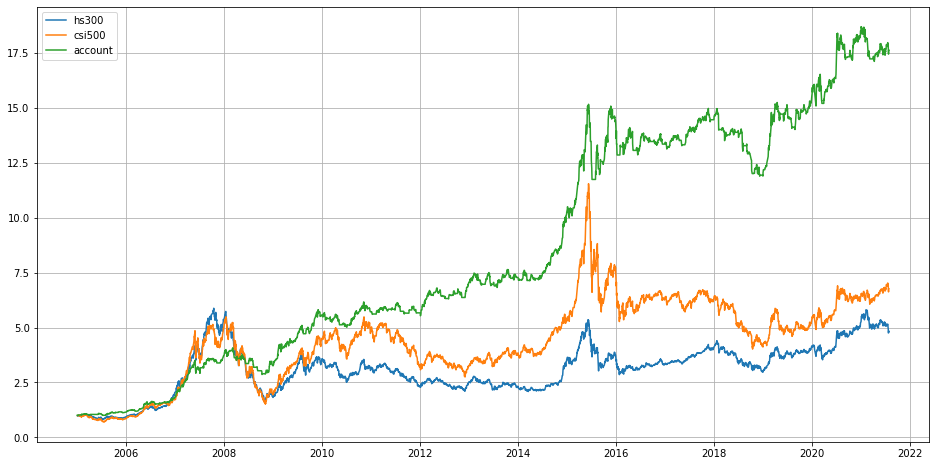

In [4]:
# 设置回测参数
start_date = datetime.date(2004,12,31) # 回测起始日期
end_date = datetime.date(2021,7,31) # 回测截止日期

# 读取基础数据
data = get_hist_data(end_date=end_date) 

# 调用策略模块生成目标组合权重
target_wgt1 = calendar_stgy(data, start_date, end_date, params={'index_id':'hs300', 't1':1, 't2':5})
target_wgt2 = calendar_stgy(data, start_date, end_date, params={'index_id':'csi1000', 't1':1, 't2':5})
target_wgt3 = rotation_stgy(data, start_date, end_date, params={'N':20})
target_wgt4 = rotation_stgy1(data, start_date, end_date, params={'N':20})
target_wgt = 0*target_wgt1 + 0.5*target_wgt2 + 0*target_wgt3 + 0.5*target_wgt4 # 多策略目标组合整合

# 产生每日持仓权重
asset_wgt = target_wgt # 假设每天都可以准确地执行交易计划

# 计算组合业绩
asset_ret = data.pct_change().loc[start_date:end_date]
res = (1+asset_ret).cumprod()
# res['stgy1'] = 
res['account'] = (1+(asset_wgt.shift(1) * asset_ret).sum(axis=1)).cumprod()

# 展示净值曲线图和业绩指标表
res.loc[:,['hs300','csi500','account']].plot(figsize=(16,8), grid=True)
cal_period_perf_indicator(res.loc[:,['hs300','csi500','account']])

# 实盘程序

In [50]:
# 开盘前
T = datetime.date(2021,8,3) # 设置拟交易日期
target_amount = 100000 # 目标投资金额

# 读取基础数据：截止到交易日前一日
end_date = T - datetime.timedelta(1)
start_date = T - datetime.timedelta(365) # 取近1年
data = get_hist_data(end_date=end_date)

target_wgt1 = calendar_stgy(data, dates=[T], params={'index_id':'hs300', 't1':1, 't2':5})
target_wgt2 = rotation_stgy1(data, dates=[T], params={'N':20})
# target_wgt3 = trend_stgy(trade_date)
# target_wgt = 0.5*target_wgt1 + 0.3*target_wgt2 + 0.2*target_wgt3
target_wgt = 0.5*target_wgt1 + 0.5*target_wgt2

# prev_hold = get_account_hold(prev_date) # read from account_DB
# target_hold = f(prev_hold, target_wgt)
# trade_order # in dollar
# trade_order.to_csv()


display(target_wgt1)
display(target_wgt2)
display(target_wgt)

基础数据包更新到2021-08-27


,csi1000,csi500,hs300,sse
2021-08-03,0,0,1,0


,csi1000,csi500,hs300,sse
2021-08-03,0,1,0,0


,csi1000,csi500,hs300,sse
2021-08-03,0.0,0.5,0.5,0.0


In [8]:
# 收盘后
trade_record_pd.read_excel('')
account_hold = f(prev_hold, trade_record)
# write to account_DB

NameError: name 'trade_record_pd' is not defined

In [9]:
# 业绩分析
